# Dataset overview for TPC-H and Amazon Reviews

Summaries, histograms, and correlation heatmaps for the two datasets used throughout the paper.


In [1]:

from pathlib import Path
import re
import math
import string
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from IPython.display import display

sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.25)
plt.rcParams.update(
    {
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
        "figure.titlesize": 20,
    }
)

NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent
STATS_DIR = REPO_ROOT / "workloads" / "stats"

DATASET_SPECS = {
    "TPC-H SF16 (lineitem)": STATS_DIR / "tpch_16_stats.yaml",
    "Amazon Reviews sample": STATS_DIR / "amazon_stats.yaml",
}


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:

NUMERIC_KINDS = {
    "double",
    "float64",
    "float32",
    "int",
    "int32",
    "int64",
    "long",
    "number",
    "decimal",
}
TEMPORAL_KINDS = {"date", "datetime", "datetime64[ns]", "timestamp"}
CATEGORICAL_KINDS = {"categorical", "string", "object", "bool", "boolean"}
KIND_TO_ALIAS = {kind: "numeric" for kind in NUMERIC_KINDS}
KIND_TO_ALIAS.update({kind: "temporal" for kind in TEMPORAL_KINDS})
KIND_TO_ALIAS.update({kind: "categorical" for kind in CATEGORICAL_KINDS})
ALIAS_COLORS = {
    "numeric": "#1b9e77",
    "temporal": "#d95f02",
    "categorical": "#7570b3",
    "other": "#666666",
}

EXPORT_FIGURES = True
FIGURE_DIR = NOTEBOOK_DIR / "figures"
HIST_COLUMNS_PER_ROW = 6
HIST_MAX_ROWS = None  # set to an int to cap the number of rows
HIST_FIG_DIMS = (4.2, 3.4)  # width, height per subplot

HIST_NORMALIZE = True  # convert counts to share of rows
HIST_YLABEL = "share of rows"

COLUMN_TITLE_OVERRIDES = {
    "l_comment": "Comment",
    "l_shipinstruct": "Ship instruct",
    "asin": "ASIN",
    "parent_asin": "Parent ASIN",
    "user_id": "User ID",
}
TOPK_LABEL_OVERRIDES = {
    "l_comment": "text",
    "l_shipinstruct": "instr",
    "asin": "asin",
    "parent_asin": "parent",
    "user_id": "user",
}
HIST_LAYOUT_OVERRIDES = {
    "TPC-H SF16 (lineitem)": {"columns_per_row": 3},
    "Amazon Reviews sample": {"columns_per_row": 3},
}  # {dataset: {"columns_per_row": int, "max_rows": int | None, "fig_dims": (w, h)}}

HIST_COLUMN_FILTERS = {}
# HIST_COLUMN_FILTERS = {
#     "TPC-H SF16 (lineitem)": ["l_commitdate", #"l_linestatus", "l_shipinstruct", 
#                               "l_shipmode", "l_returnflag", "l_quantity", "l_extendedprice", "l_discount"],
#     "Amazon Reviews sample": ["asin",  "helpful_vote", "verified_purchase", #"category", "parent_asin", 
#                               "user_id", "record_timestamp", "rating"]
# }
"""Optional per-dataset ordered column lists used to limit histogram panels."""


def dataset_slug(name: str) -> str:
    slug = re.sub(r"[^0-9a-z]+", "_", name.lower()).strip("_")
    return slug or "dataset"


def column_alias(meta) -> str:
    kind = (meta.get("kind") or "").lower()
    return KIND_TO_ALIAS.get(kind, "other")


def column_color(meta) -> str:
    return ALIAS_COLORS.get(column_alias(meta), "#333333")




def subplot_label(index: int) -> str:
    letters = string.ascii_lowercase
    base = len(letters)
    chars = []
    value = index
    while True:
        value, rem = divmod(value, base)
        chars.append(letters[rem])
        if value == 0:
            break
        value -= 1
    return f"({''.join(reversed(chars))})"


def subplot_labels(count: int):
    return [subplot_label(i) for i in range(count)]


def column_title(column: str) -> str:
    return COLUMN_TITLE_OVERRIDES.get(column, column)


def save_figure(fig, name: str) -> None:
    if not EXPORT_FIGURES:
        return
    FIGURE_DIR.mkdir(parents=True, exist_ok=True)
    output = FIGURE_DIR / f"{name}.pdf"
    fig.savefig(output, bbox_inches="tight")
    print(f"Saved figure to {output}")


def load_dataset_stats():
    dataset_stats = {}
    for name, path in DATASET_SPECS.items():
        if not path.exists():
            raise FileNotFoundError(f"Missing stats file: {path}")
        with path.open() as fh:
            dataset_stats[name] = yaml.safe_load(fh)
        print(name)
    return dataset_stats


def build_column_frame(stats):
    rows = []
    for column, meta in stats["columns"].items():
        count = meta.get("count") or 0
        nulls = meta.get("nulls", 0) or 0
        rows.append(
            {
                "column": column,
                "kind": meta.get("kind"),
                "cardinality": meta.get("cardinality"),
                "rows_seen": count,
                "null_fraction": (nulls / count) if count else 0.0,
                "min": meta.get("min"),
                "max": meta.get("max"),
            }
        )
    return pd.DataFrame(rows)


def summarize_dataset(name, stats, column_frame=None):
    column_frame = column_frame if column_frame is not None else build_column_frame(stats)
    kind_series = column_frame["kind"].fillna("").str.lower()
    cardinalities = column_frame["cardinality"].dropna()
    summary = {
        "Dataset": name,
        "Columns": len(column_frame),
        "Numeric columns": int(kind_series.isin(NUMERIC_KINDS).sum()),
        "Categorical columns": int(kind_series.isin(CATEGORICAL_KINDS).sum()),
        "Temporal columns": int(kind_series.isin(TEMPORAL_KINDS).sum()),
        "Min cardinality": int(cardinalities.min()) if not cardinalities.empty else None,
        "Max cardinality": int(cardinalities.max()) if not cardinalities.empty else None,
    }
    return summary, column_frame


def histogram_payload(meta):
    hist = meta.get("hist")
    if not hist or not hist[0]:
        return None
    counts = np.asarray(hist[0], dtype=float)
    edges = np.asarray(hist[1], dtype=float)
    if len(edges) > len(counts) + 1:
        edges = edges[: len(counts) + 1]
    elif len(edges) < len(counts) + 1:
        edges = np.append(edges, edges[-1])
    return counts, edges


def topk_payload(meta, limit=20):
    topk = meta.get("topk") or []
    if not topk:
        return None
    pairs = []
    for value, count in topk[:limit]:
        label = "NULL" if value is None else str(value)
        pairs.append((label, float(count)))
    labels, counts = zip(*pairs)
    return list(labels), np.asarray(counts)






def plot_hist(ax, column, meta, prefix=None):
    payload = histogram_payload(meta)
    color = column_color(meta)
    title = column_title(column)
    if prefix:
        title = f"{prefix} {title}"
    if payload is not None:
        counts, edges = payload
        kind = (meta.get("kind") or "").lower()
        if HIST_NORMALIZE:
            total = counts.sum()
            if total:
                counts = counts / total
        if kind in TEMPORAL_KINDS:
            bin_edges = pd.to_datetime(edges, unit="ms", errors="coerce")
            mask = ~bin_edges.isna()
            bin_edges = bin_edges[mask]
            counts = counts[: len(bin_edges) - 1]
            bin_nums = mdates.date2num(bin_edges.to_pydatetime())
            widths = np.diff(bin_nums)
            ax.bar(bin_edges[:-1], counts, width=widths, align="edge", color=color)
            locator = mdates.AutoDateLocator()
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        else:
            widths = np.diff(edges)
            ax.bar(edges[:-1], counts, width=widths, align="edge", color=color)
        ylabel = HIST_YLABEL if HIST_NORMALIZE else "rows per bin"
        ax.set_ylabel(ylabel)
        ax.set_xlabel(title)
        ax.tick_params(axis="x", labelbottom=False)
        # Subplot titles are moved onto the x-axis label to avoid overlap.
        return
    topk = topk_payload(meta)
    if topk is not None:
        labels, counts = topk
        if HIST_NORMALIZE:
            total = counts.sum()
            if total:
                counts = counts / total
        positions = np.arange(len(labels))
        ax.bar(positions, counts, color=color)
        ax.set_xticks(positions)
        ax.tick_params(axis="x", labelbottom=False)
        ylabel = HIST_YLABEL if HIST_NORMALIZE else "rows"
        ax.set_ylabel(ylabel)
        ax.set_xlabel(title)
        # Subplot titles are moved onto the x-axis label to avoid overlap.
        return
    ax.text(0.5, 0.5, "no distribution stats", ha="center", va="center", transform=ax.transAxes)
    ax.set_axis_off()


def correlation_frame(stats, method="pearson"):
    corr = stats.get("metadata", {}).get("correlations", {}).get(method)
    if not corr:
        return None
    df = pd.DataFrame(corr)
    columns = list(df.columns)
    return df.loc[columns, columns]


dataset_stats = load_dataset_stats()
column_frames = {name: build_column_frame(stats) for name, stats in dataset_stats.items()}


TPC-H SF16 (lineitem)
Amazon Reviews sample


In [6]:

summary_rows = []
for name, stats in dataset_stats.items():
    summary, frame = summarize_dataset(name, stats, column_frames[name])
    column_frames[name] = frame
    summary_rows.append(summary)
summary_df = pd.DataFrame(summary_rows).set_index("Dataset")
display(summary_df)

dtype_breakdown = (
    pd.DataFrame({name: frame["kind"].value_counts() for name, frame in column_frames.items()})
    .fillna(0)
    .astype(int)
    .T
)
display(dtype_breakdown)

for name, frame in column_frames.items():
    display(frame.sort_values("column").reset_index(drop=True).assign(dataset=name).head())


,Columns,Numeric columns,Categorical columns,Temporal columns,Min cardinality,Max cardinality
Dataset,,,,,,
TPC-H SF16 (lineitem),17,0,5,3,2,20000
Amazon Reviews sample,8,0,5,1,1,20000


kind,boolean,categorical,datetime,numeric
TPC-H SF16 (lineitem),0,5,3,9
Amazon Reviews sample,1,4,1,2


,column,kind,cardinality,rows_seen,null_fraction,min,max,dataset
0,l_comment,categorical,20000,200000,0.0,NaN,NaN,TPC-H SF16 (lineitem)
1,l_commitdate,datetime,2452,200000,0.0,6.969024e+11,9.097056e+11,TPC-H SF16 (lineitem)
2,l_discount,numeric,11,200000,0.0,0.000000e+00,1.000000e-01,TPC-H SF16 (lineitem)
3,l_extendedprice,numeric,19833,200000,0.0,9.109100e+02,1.038445e+05,TPC-H SF16 (lineitem)
4,l_linenumber,numeric,7,200000,0.0,1.000000e+00,7.000000e+00,TPC-H SF16 (lineitem)


,column,kind,cardinality,rows_seen,null_fraction,min,max,dataset
0,asin,categorical,20000,200000,0.0,NaN,NaN,Amazon Reviews sample
1,category,categorical,1,200000,0.0,NaN,NaN,Amazon Reviews sample
2,helpful_vote,numeric,70,200000,0.0,0.0,646.0,Amazon Reviews sample
3,parent_asin,categorical,20000,200000,0.0,NaN,NaN,Amazon Reviews sample
4,rating,numeric,5,200000,0.0,1.0,5.0,Amazon Reviews sample


Saved figure to /home/unimelb.edu.au/guanlil1/Documents/lakehouse/notebooks/figures/tpc_h_sf16_lineitem_histograms.pdf


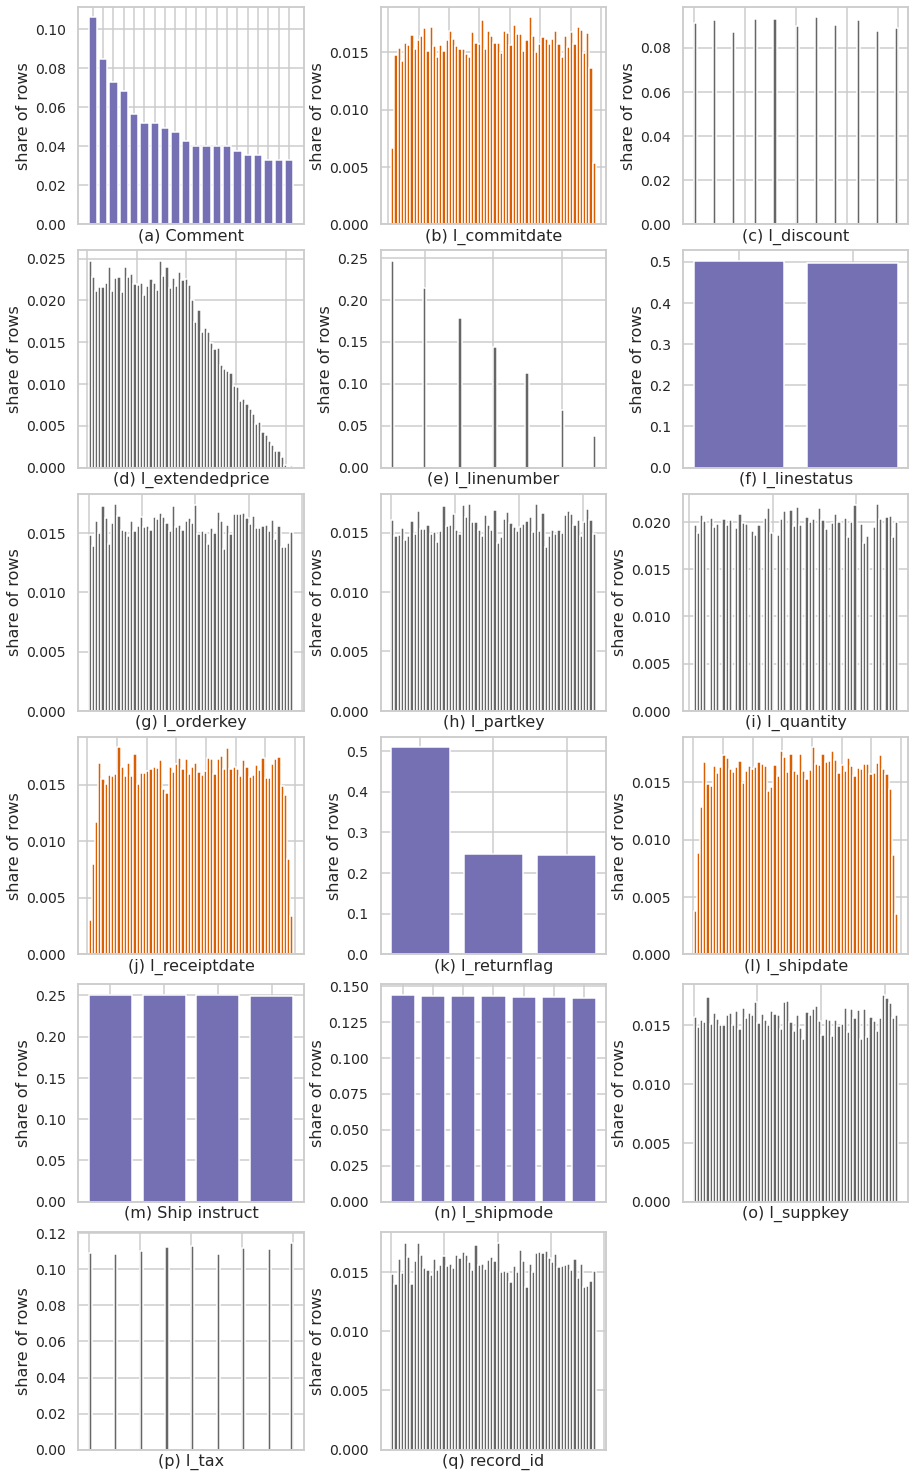

Saved figure to /home/unimelb.edu.au/guanlil1/Documents/lakehouse/notebooks/figures/amazon_reviews_sample_histograms.pdf


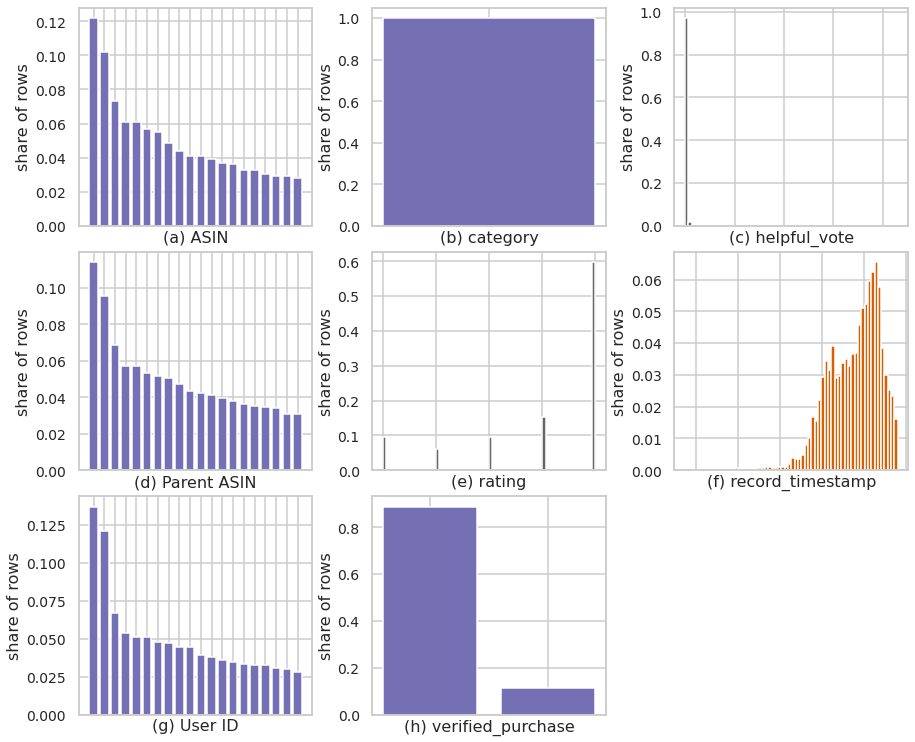

In [7]:

for name, stats in dataset_stats.items():
    if stats is None:
        continue
    columns = list(stats["columns"].keys())
    selected_columns = HIST_COLUMN_FILTERS.get(name)
    if selected_columns:
        columns = [col for col in selected_columns if col in stats["columns"]]
    if not columns:
        continue
    layout = HIST_LAYOUT_OVERRIDES.get(name, {})
    columns_per_row = layout.get("columns_per_row", HIST_COLUMNS_PER_ROW)
    max_rows = layout.get("max_rows", HIST_MAX_ROWS)
    fig_dims = layout.get("fig_dims", HIST_FIG_DIMS)
    ncols = min(max(1, columns_per_row), len(columns))
    nrows = math.ceil(len(columns) / ncols)
    if max_rows is not None and nrows > max_rows:
        nrows = max_rows
        ncols = math.ceil(len(columns) / nrows)
    width, height = fig_dims
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(width * ncols, height * nrows),
        constrained_layout=True,
    )
    axes = np.atleast_1d(axes).ravel()
    labels = subplot_labels(len(columns))
    for ax, column, label in zip(axes, columns, labels):
        plot_hist(ax, column, stats["columns"][column], prefix=label)
    for ax in axes[len(columns) :]:
        ax.remove()
#     fig.suptitle(f"{name} – attribute distributions", y=1.02)
    save_figure(fig, f"{dataset_slug(name)}_histograms")
    plt.show()


Saved figure to /home/unimelb.edu.au/guanlil1/Documents/lakehouse/notebooks/figures/tpc_h_sf16_lineitem_correlation.pdf


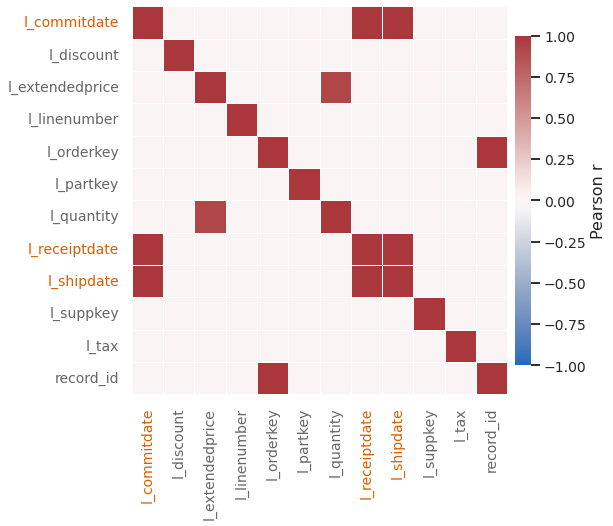

Saved figure to /home/unimelb.edu.au/guanlil1/Documents/lakehouse/notebooks/figures/amazon_reviews_sample_correlation.pdf


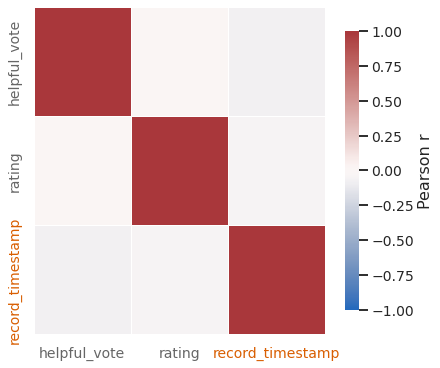

In [8]:
for name, stats in dataset_stats.items():
    corr_df = correlation_frame(stats, method="pearson")
    if corr_df is None or corr_df.empty:
        continue
    ncols = len(corr_df.columns)
    fig_width = max(6, 0.7 * ncols)
    fig_height = max(5, 0.6 * ncols)
    fig, ax = plt.subplots(
        figsize=(fig_width, fig_height),
        constrained_layout=True,
    )
    sns.heatmap(
        corr_df,
        ax=ax,
        cmap="vlag",
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        cbar_kws={"label": "Pearson r", "shrink": 0.85, "pad": 0.02},
    )
#     ax.set_title(f"{name} – correlation heatmap")
    dtype_lookup = (
        column_frames[name]
        .set_index("column")["kind"]
        .fillna("")
        .str.lower()
        .to_dict()
    )
    # Axis tick colors still denote column type even without a dedicated legend.
    for tick in ax.get_xticklabels():
        alias = KIND_TO_ALIAS.get(dtype_lookup.get(tick.get_text(), ""), "other")
        tick.set_color(ALIAS_COLORS.get(alias, "#333333"))
    for tick in ax.get_yticklabels():
        alias = KIND_TO_ALIAS.get(dtype_lookup.get(tick.get_text(), ""), "other")
        tick.set_color(ALIAS_COLORS.get(alias, "#333333"))
    save_figure(fig, f"{dataset_slug(name)}_correlation")
    plt.show()